## Dlib-eos (Supports multiple faces)
#### Steps:
 * Load image and extract facial landmarks using dlib.
 * Fit a face mesh (we'll be using Surrey Face Model) to the extracted landmarks using eos.
 * Render the mesh as 2d points on the image.

In [1]:
import numpy as np
import dlib
import eos
from imageio import imread

In [2]:
# for drawing on jupyter
from io import BytesIO
import PIL.Image
import IPython.display
from skimage.draw import circle

In [3]:
# drawing functions
def show_img(a, fmt='png'):
    a = np.uint8(np.clip(a, 0, 255))
    data = BytesIO()
    PIL.Image.fromarray(a).save(data, fmt)
    IPython.display.display(IPython.display.Image(data=data.getvalue()))
    
def draw_circle(canvas, x, y, r=2, color=(255,255,255)):
    rr,cc = circle(x,y,r,shape=canvas.shape)
    canvas[rr,cc] = color

# get viewport matrix
def viewport_matrix(w,h):
    viewport = np.array([0,h,w,-h])
    
    # scale
    S = np.identity(4,dtype=np.float32)
    S[0][0] *= viewport[2]/2
    S[1][1] *= viewport[3]/2
    S[2][2] *= 0.5
    
    # translate
    T = np.identity(4,dtype=np.float32)
    T[3][0] = viewport[0] + (viewport[2]/2)
    T[3][1] = viewport[1] + (viewport[3]/2)
    T[3][2] = 0.5
    return S@T

In [4]:
# load detector,shape predictor and image
detector = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor('res/68.dat')
img = imread('2.jpg')

# get bounding box and facial landmarks
boxes = detector(img)
lp = []
for box in boxes:
    shape = shape_predictor(img, box)
    index = 1
    landmarks = []
    for part in shape.parts():
        landmarks.append(eos.core.Landmark(str(index),[float(part.y),float(part.x)]))
        index +=1
    lp.append(landmarks)

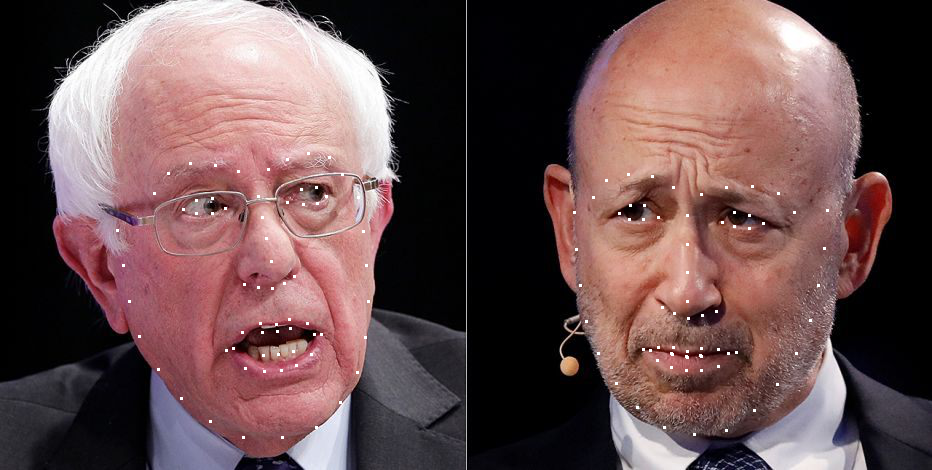

In [5]:
# rendering image with 68 landmarks (for debugging)
canvas = img.copy()
for landmarks in lp:
    for point in landmarks: draw_circle(canvas, point.coordinates[0],point.coordinates[1])
show_img(canvas)

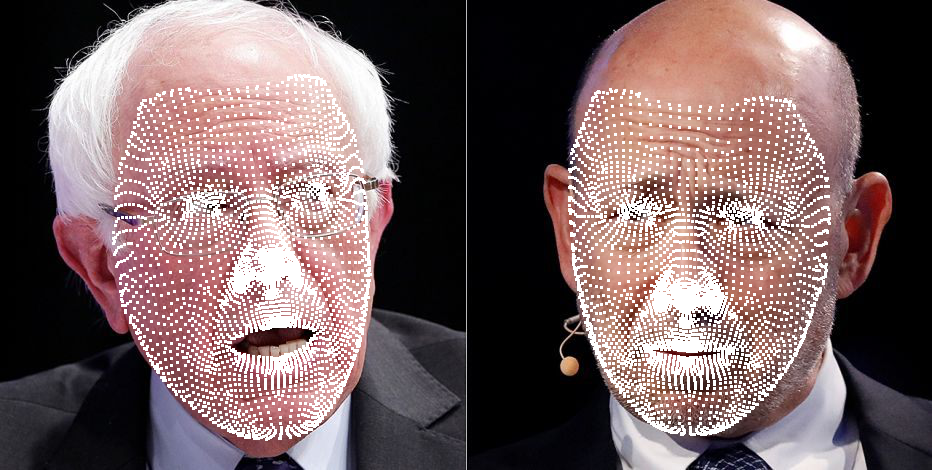

In [6]:
model = eos.morphablemodel.load_model("res/sfm_shape_3448.bin")
blendshapes = eos.morphablemodel.load_blendshapes("res/expression_blendshapes_3448.bin")
morphablemodel_with_expressions = eos.morphablemodel.MorphableModel(
    model.get_shape_model(), 
    blendshapes,
    color_model=eos.morphablemodel.PcaModel(),
    texture_coordinates=model.get_texture_coordinates()
)
landmark_mapper = eos.core.LandmarkMapper('res/ibug_to_sfm.txt')
edge_topology = eos.morphablemodel.load_edge_topology('res/sfm_3448_edge_topology.json')
contour_landmarks = eos.fitting.ContourLandmarks.load('res/ibug_to_sfm.txt')
model_contour = eos.fitting.ModelContour.load('res/sfm_model_contours.json')

h,w = img.shape[:2]
vm = viewport_matrix(w,h)
canvas = img.copy()
for landmarks in lp:
    mesh, pose, shape_coeffs, blendshape_coeffs = eos.fitting.fit_shape_and_pose(
        morphablemodel_with_expressions,
        landmarks, landmark_mapper, w, h, edge_topology, 
        contour_landmarks,model_contour)
    p = pose.get_projection()
    mv = pose.get_modelview()
    fm = vm@p@mv
    for i in mesh.vertices:
        tmp = fm@np.append(i,1)
        # disregard z and draw 2d pt
        x,y = (int(w/2+tmp[0]),int(h/2+tmp[1]))
        draw_circle(canvas,x,y)

# display result
show_img(canvas)